### Import libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:82.5% !important}</style>'))

In [2]:
import datetime

import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor

from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold, learning_curve

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Paths to directories and files

In [4]:
TRAIN_DATASET_PATH = 'data/train.csv'
TEST_DATASET_PATH = 'data/test.csv'
RES_PATH = 'data/result_submission.csv'

### Loading data

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

### Functions

In [6]:
def evaluate_preds(true_values, pred_values, save=False): 
    print('R2:\t' + str(round(r2_score(true_values, pred_values), 3)) + '\n') 
    plt.figure(figsize=(8, 10))
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig('evaluate_preds.png')
    plt.show()

In [7]:
def show_learning_curve_plot(estimator, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='r2',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15, 8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

    plt.title(f'Learning curves ({type(estimator).__name__})')
    plt.xlabel('Training examples')
    plt.ylabel('Score')     
    plt.legend(loc='best')
    plt.grid()
    plt.show()

### Feature engineering

In [8]:
class FeatureImputer:
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()        
    
    @staticmethod
    def year_norm(x):
        x = str(x)
        if len(x) > 4 and x[0] in ['1', '2']:
            return int(x[:4])
        elif len(x) == 4 and (not x[0] in ['1', '2']):
            if int(x[1]) == 0:
                x[0] = '2'
                return int(x)
            else:
                x[0] = '1'
                return int(x)
        else:
            return datetime.datetime.now().year
    
   
    def transform(self, X):
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > 2020, 'HouseYear'] = X.loc[X['HouseYear'] > 2020, 'HouseYear'].agg(self.year_norm)
                
        X.loc[X['Square'] < 10, 'Square'] *= 10
        X.loc[X['Square'] > 300, 'Square'] /= 10

        X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 6)) & (X['Square'] < 50), 'Rooms'] = 1
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 6)) & (X['Square'] >= 50) & (X['Square'] < 90), 'Rooms'] = 2
        X.loc[((X['Rooms'] == 0) | (X['Rooms'] > 6)) & (X['Square'] >= 90), 'Rooms'] = 3
                           
        if 'HouseFloor' in X.columns:
            X['HouseFloor_outlier'] = 0
            X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1

            X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']

            X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']  
              
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            

        X['DistrictId'] = X['DistrictId'].astype('category')
        
        return X

In [9]:
class FeatureGenetator():

    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_floor_year = None
        self.mapping_year_kethen = None
        self.district_counts = None
        self.df = None
        self.med_param_s = None
        
        
    def fit(self, X, y=None):    
        X = X.copy()
        
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  
        
        self.DistrictId_counts = district
      
        self.district_counts = np.log(X['DistrictId'].value_counts() * 100 / X['DistrictId'].value_counts().max() + 1) * 100 // 10
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        X = self.year_to_cat(X)
        
        df = X.copy()
        
        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            X['S_LfS'] = X['Square'] - X['KitchenSquare'] - X['LifeSquare']
            X['Group_Square'] = X['Square'].round() // 10 * 10
            self.df = X.loc[~X['LifeSquare'].isna() & (X['KitchenSquare'] > 1) & (X['Group_Square'] >= 30) & (X['Group_Square'] <= 90)].copy()
            self.med_param_s = self.df.groupby(['Group_Square', 'year_cat']).agg({'KitchenSquare':'median', 'S_LfS':'median'}).rename(columns={'KitchenSquare':'MedKitchenSquare', 'S_LfS': 'MedS_LfS'})
            
        
        if y is not None:
            df['Price'] = y.values
            df['Price'] /= df['Square']
            
            df['DistrictId_popular'] = df['DistrictId']
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
        df = self.year_to_cat(df)
        if y is not None:
            df['Price'] = y.values
            df['Price'] /= df['Square']
            df = self.floor_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat']).agg({'Price': 'median'}).rename(columns={'Price': 'MedPriceByFloorYear'})
            
        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            self.mapping_rooms_kethen = df.groupby('Rooms')['KitchenSquare'].median().round(0).to_dict()

        
    def transform(self, X):
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['Group_Square'] = X['Square'].round() // 10 * 10
        
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        X.drop(['Ecology_2', 'Ecology_3'], axis=1, inplace=True)
        
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        X['Group_Square'] = X['Square'].round()//10*10
        X.loc[X['Group_Square'] > 90, 'Group_Square'] = 90
        X.loc[X['Group_Square'] < 30, 'Group_Square'] = 30
        X = X.merge(self.med_param_s, on=['Group_Square', 'year_cat'], how='left')
        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            X['S_LfS'] = X['Square'] - X['KitchenSquare'] - X['LifeSquare']
            X['MedS_LfS'] = X['S_LfS'] - X['MedS_LfS']
            
        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            X.loc[X['KitchenSquare'] > X['Square'] / 2, 'KitchenSquare'] = 1 
            X['S_new'] = 0
            
            X['S_LfS'] = X['Square'] - X['KitchenSquare'] - X['LifeSquare']

            X.loc[X['KitchenSquare'] < 2, 'S_new'] = 1
            X.loc[X['KitchenSquare'] < 2, 'KitchenSquare'] = X.loc[(X['KitchenSquare'] < 2), 'MedKitchenSquare']
            X.loc[X['LifeSquare'].isna(), 'S_new'] = 1
            X.loc[X['LifeSquare'].isna(), 'LifeSquare'] = X.loc[X['LifeSquare'].isna(), 'Square'] - X.loc[X['LifeSquare'].isna(), 'KitchenSquare'] - X.loc[X['LifeSquare'].isna(), 'MedS_LfS']
            X['S_LfS'] = X['Square'] - X['KitchenSquare'] - X['LifeSquare']
            
            X.loc[(X['LifeSquare'] - X['Square']).abs() > 150, 'S_new'] = 1

            X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = X.loc[X['LifeSquare'] < 10, 'Square'] - X.loc[X['LifeSquare'] < 10, 'LifeSquare']

            X['Square_new'] = X.loc[(X['Square'] - X['LifeSquare'] < X['KitchenSquare']) & (X['Square'] < X['LifeSquare']), 'Square']
            X['LifeSquare_new'] = X.loc[(X['Square'] - X['LifeSquare'] < X['KitchenSquare']) & (X['Square'] < X['LifeSquare']), 'LifeSquare']
            X.loc[~X['Square_new'].isna(), 'Square'] = X.loc[~X['Square_new'].isna(), 'LifeSquare_new']
            X.loc[~X['LifeSquare_new'].isna(), 'LifeSquare'] = X.loc[~X['LifeSquare_new'].isna(), 'Square_new']

            X.loc[~X['LifeSquare_new'].isna(), 'S_new'] = 1
            X.loc[(X['Square'] - X['LifeSquare'] < X['KitchenSquare']), 'S_new'] = 1
            X.drop(['Square_new', 'LifeSquare_new'], axis=1, inplace=True)

            X.loc[(X['Square'] - X['LifeSquare'] < X['KitchenSquare']), 'LifeSquare'] = X.loc[(X['Square'] - X['LifeSquare'] < X['KitchenSquare']), 'LifeSquare'] - X.loc[(X['Square']-X['LifeSquare']< X['KitchenSquare']), 'KitchenSquare']
         

        if 'KitchenSquare' in X.columns and 'LifeSquare' in X.columns:
            X['MedKitchenSquare_D'] = X['Rooms'].map(self.mapping_rooms_kethen)
            X['Square*MedKitchenSquare_D'] =  X['Square'] * X['MedKitchenSquare_D']
            X['HouseFloor*Social_3'] =  X['HouseFloor'] * X['Social_3']
    
        X['Square*MedPriceByFloorYear'] =  X['Square'] * X['MedPriceByFloorYear']
        X['DistrictId_count*MedPriceByFloorYear'] = X['DistrictId_count'] *  X['MedPriceByFloorYear']
        X['HouseYear*DistrictId_count'] =  X['HouseYear'] * X['DistrictId_count']
        X['Square*new_district'] =  X['Square'] * X['new_district']
        X['Social_3*new_district'] =  X['Social_3'] * X['new_district']
        X['Rooms*Social_1'] =  X['Rooms'] *  X['Social_1']
        X['Rooms*MedPriceByFloorYear'] =  X['Rooms'] * X['MedPriceByFloorYear']
                 
        X['Soc_1*Soc_2'] = X['Social_2'] * X['Social_1']
        X['Soc_2*Soc_3'] = X['Social_2'] * X['Social_3']
        X['Soc_3*Eco_1'] = X['Social_3'] * X['Ecology_1'] 
        
        X['DistrictId_count'] = X['DistrictId'].map(self.district_counts)
        
        X.fillna(0, inplace=True)
        
        return X
    
    @staticmethod
    def floor_to_cat(X):      
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):    
        X['year_cat'] = np.nan
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 6
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 7
        X.loc[(X['HouseYear'] == 1977), 'year_cat'] = 4
        X['year_cat'] = X['year_cat'].astype('category')
        
        return X

In [10]:
X = train_df
y = train_df['Price']

preds_final = pd.DataFrame()
preds_final['Id'] = test_df['Id'].copy()

X.set_index('Id', inplace=True)
test_df.set_index('Id', inplace=True)

del train_df

In [11]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
test_df = imputer.transform(test_df)

In [12]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
test_df = features.transform(test_df)

### Correlation

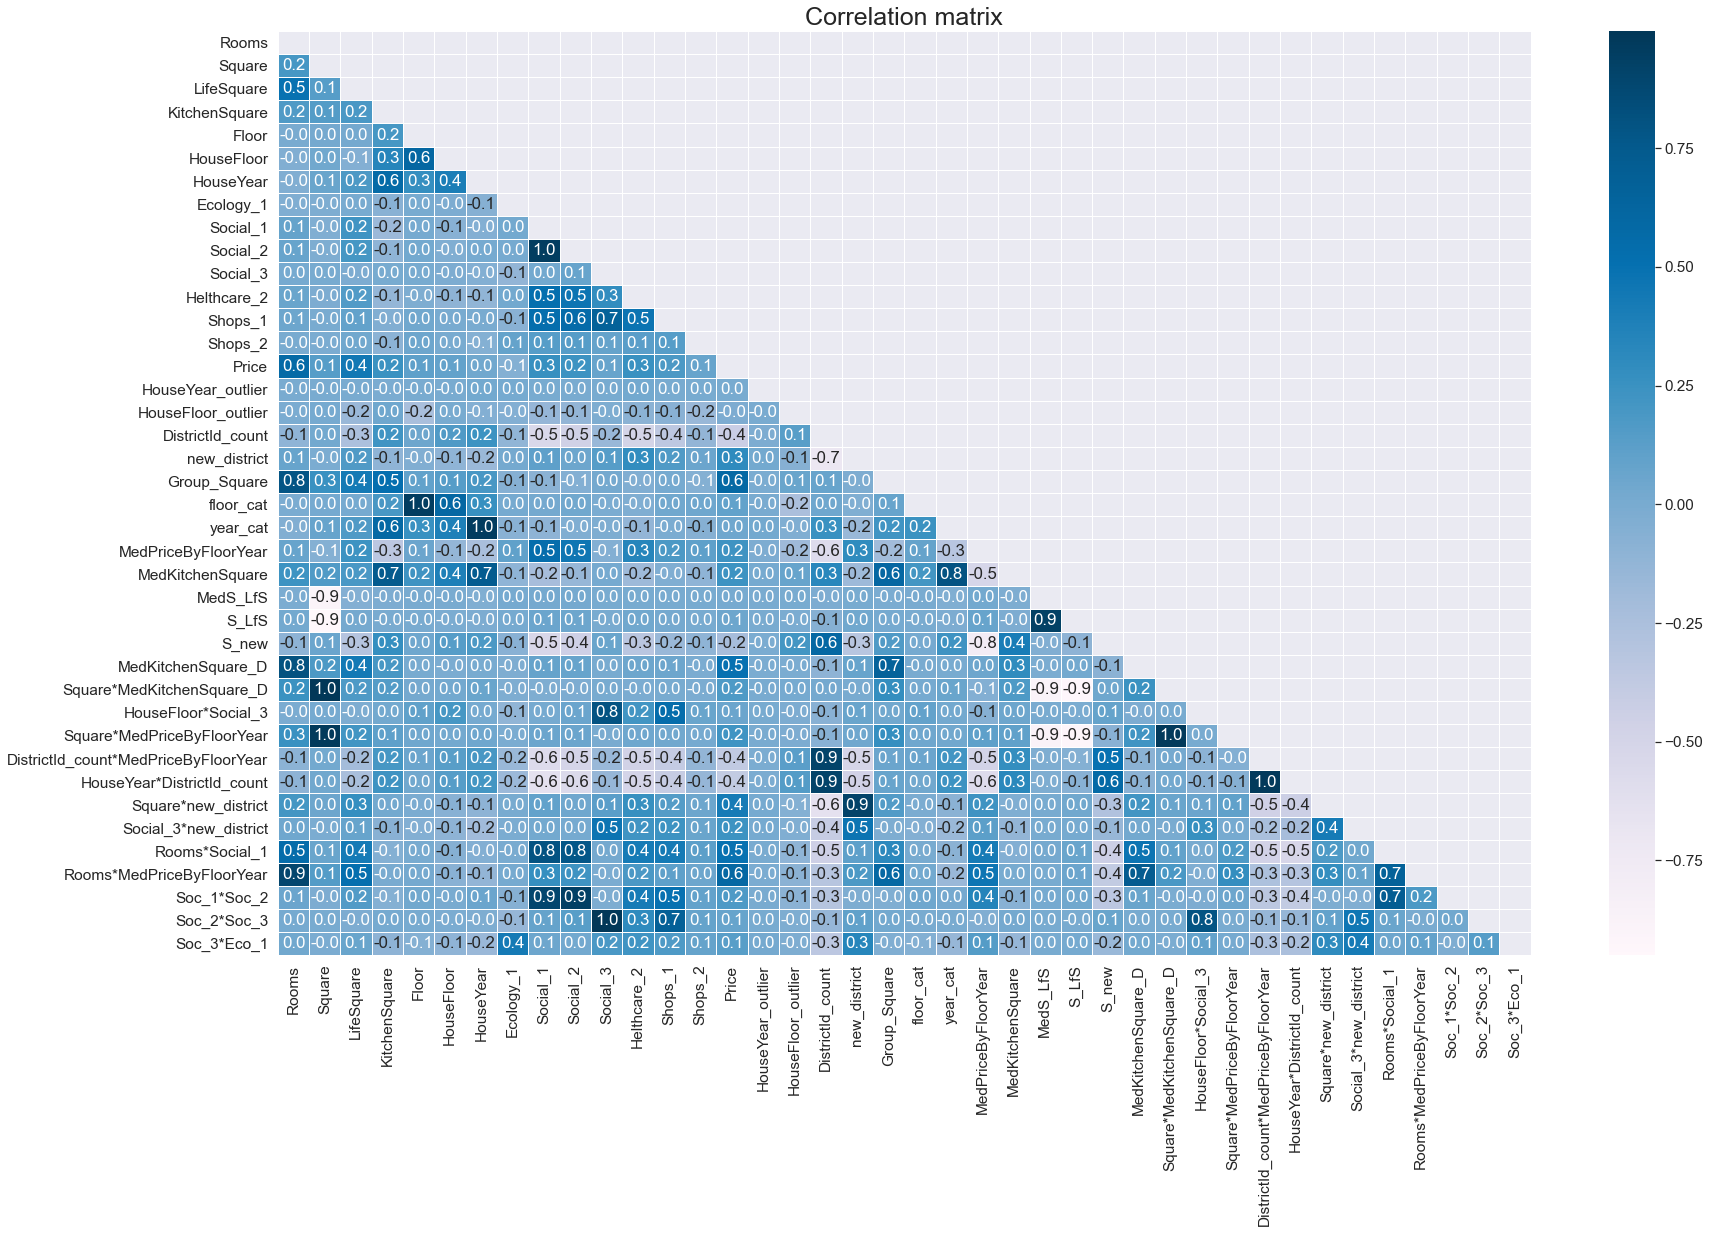

In [13]:
# Correlation Matrix
num_features = pd.DataFrame(X)

corr = num_features.corr()
plt.figure(figsize = (25, 17))
mask = np.zeros_like(corr, dtype=np.bool)  # отрезаем лишнюю половину матрицы
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=1.4)
sns.heatmap(num_features.corr(), mask=mask, annot=True, fmt='.1f', linewidths=.5, cmap='PuBu')
plt.title('Correlation matrix', fontsize=25)
plt.show()

In [14]:
correlation = X.corr()
corr_with_target = correlation['Price'].sort_values(ascending = False)
corr_with_target

Price                                   1.000000
Rooms*MedPriceByFloorYear               0.594686
Group_Square                            0.587158
Rooms                                   0.571421
MedKitchenSquare_D                      0.501130
Rooms*Social_1                          0.490684
LifeSquare                              0.445765
Square*new_district                     0.424149
new_district                            0.304008
Social_1                                0.263286
Helthcare_2                             0.253090
KitchenSquare                           0.249071
MedKitchenSquare                        0.242084
Social_2                                0.239226
Social_3*new_district                   0.238034
MedPriceByFloorYear                     0.229513
Square*MedPriceByFloorYear              0.222590
Shops_1                                 0.180876
Square*MedKitchenSquare_D               0.170937
Soc_1*Soc_2                             0.170677
Square              

### Building the model

In [15]:
X.drop('Price', axis=1, inplace=True)

#### GradientBoostingRegressor

In [16]:
model_gbr = GradientBoostingRegressor(n_estimators=200, max_depth=5, min_samples_split=20, learning_rate=0.1, loss='huber', random_state=42)

#### LGBMRegressor

In [17]:
model_lgbmr = LGBMRegressor(max_depth=7, n_estimators=150, random_state=42, n_jobs=-1)

#### VotingRegressor

In [18]:
model_vr = VotingRegressor([('model_gbr', model_gbr), ('model_lgbmr', model_lgbmr)])

#### Cross-validation

In [19]:
%%time
cv_score = cross_val_score(model_vr, X, y, scoring='r2', cv=KFold(n_splits=10, shuffle=True, random_state=42))

Wall time: 1min 56s


In [20]:
print(f'Mean R2 score: {round(np.mean(cv_score), 4)}, std: {round(np.std(cv_score), 4)}')

Mean R2 score: 0.7627, std: 0.0256


In [21]:
model_vr.fit(X, y)

VotingRegressor(estimators=[('model_gbr',
                             GradientBoostingRegressor(loss='huber',
                                                       max_depth=5,
                                                       min_samples_split=20,
                                                       n_estimators=200,
                                                       random_state=42)),
                            ('model_lgbmr',
                             LGBMRegressor(max_depth=7, n_estimators=150,
                                           random_state=42))])

R2:	0.89



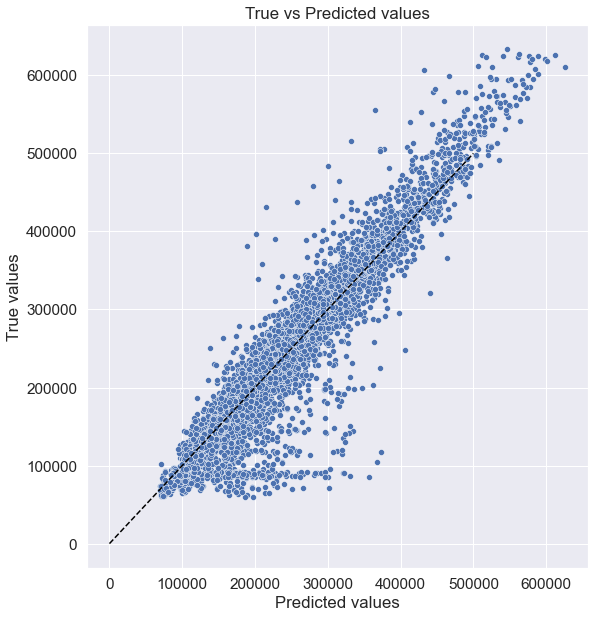

In [22]:
train_predictions = model_vr.predict(X)
evaluate_preds(y, train_predictions)

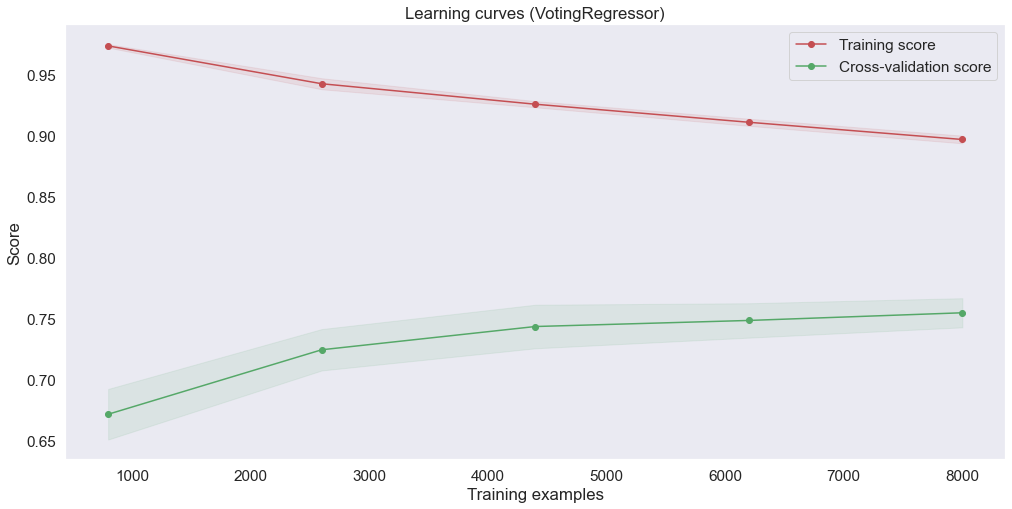

In [23]:
show_learning_curve_plot(model_vr, X, y)

### Result

In [24]:
predictions = model_vr.predict(test_df)

In [25]:
preds_final['Price'] = pd.DataFrame({'Price': predictions})

In [26]:
preds_final.to_csv(RES_PATH, index=False)

In [27]:
preds_final.head()

,Id,Price
0,725,167018.359353
1,15856,217080.086743
2,5480,249204.968061
3,15664,348894.058035
4,14275,143769.863210
